In [1]:
%pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.3 MB/s eta 0:00:00


**YOUR_SURNAME YOUR_FRISTNAME**

The goal is to train evolutoinary algorithm to solve classic optimization function. The function is **Rastrigin** function, but it is reversed and shifted.
The maximum value that you can achieve is 10 and this is your goal!

Send me a link to your colab notebook to
***michael.melnik@itmo.ru***

In [2]:
import numpy
import deap
import math
import numpy as np
from deap import tools, base, creator, algorithms
import numpy.random as rnd


In [3]:
#Shifted Rastrigin function

noise = rnd.random(1000)

def rastrigin(individual):
    individual = individual + noise[0:len(individual)]
    n = len(individual)

    pi = math.pi
    dn = 1.0 / n
    a = 10.0
    b = 0.2
    c = 2 * pi
    s1 = 0.0
    s2 = 0.0
    for i in range(n):
        s1 += individual[i] * individual[i]
        s2 += np.cos(c*individual[i])
    s1 = -a * math.exp(-b*math.sqrt(dn*s1))
    s2 = -math.exp(dn*s2)
    result = s1+s2 + a + math.exp(1)
    result = -result
    result = result + a
    result = math.fabs(result)
    return result

In [4]:
solution = [0 for _ in range(20)]
rastrigin(solution)

7.469300186939364

In [5]:
creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)


In [6]:
def mutation(individual):
    n = len(individual)
    for i in range(n):
        if rnd.random() < n * 0.15:
            individual[i] += rnd.normal(0.0, 0.2)
            individual[i] = np.clip(individual[i], -5, 5)
    return individual,

In [ ]:
# first i changed mate & mutate to cxUniform & mutShuffleIndexes , it shows increasing of quality
# also i incrase mut_prob , and it shows better quality to near 0.93
# change mutShuffleIndexes , indpb from 0.25 t0 0.45 , and it shows much better improvement of quality , converge very fast
# set tournsize = 3 in selTournament , and finally quality reached at max 0.95
# with inspb of cxUniform more than 0.15 (i tired 0.2, 0.3), quality can reach at max to 0.95

In [225]:
class SimpleGAExperiment:
    def factory(self):
        return rnd.random(self.dimension) * 10 - 5 # random range from -5 to 5

    def __init__(self, function, dimension, pop_size, iterations):
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = 0.7
        self.cross_prob = 0.3

        self.function = function
        self.dimension = dimension

        # self.pool = Pool(5)
        self.engine = base.Toolbox()
        # self.engine.register("map", self.pool.map)
        self.engine.register("map", map)
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register("population", tools.initRepeat, list, self.engine.individual, self.pop_size)
        #self.engine.register("mate", tools.cxOnePoint)
        self.engine.register("mate", tools.cxUniform, indpb=0.2)
        #self.engine.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2)
        #self.engine.register("mutate", tools.mutFlipBit, indpb=0.2)

        self.engine.register("mutate", tools.mutShuffleIndexes, indpb=0.45)
        # self.engine.register("mutate", mutation)
        self.engine.register("select", tools.selTournament, tournsize=2)
        #self.engine.register("select", tools.selRoulette)
        self.engine.register("evaluate", self.function)


    def run(self):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, np.array_equal)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = algorithms.eaMuPlusLambda(pop, self.engine, mu=self.pop_size, lambda_=int(self.pop_size*0.8), cxpb=self.cross_prob, mutpb=self.mut_prob,
                                  ngen=self.iterations,
                                  stats=stats, halloffame=hof, verbose=True)
        print("Best = {}".format(hof[0]))
        print("Best fit = {}".format(hof[0].fitness.values[0]))
        return log

In [226]:
def function(x):
    res = rastrigin(x)
    return res,

dimension = 100 # set it to 100
pop_size = 100 # lets say max is 100
iterations = 5000 # lets say max is 5000
scenario = SimpleGAExperiment(function, dimension, pop_size, iterations)

In [227]:
import matplotlib.pyplot as plt
import numpy as np

def read_log(log):
    avg_list = list()
    std_list = list()
    min_list = list()
    max_list = list()
    gen_list = list()
    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    return np.array(gen_list), np.array(avg_list), np.array(std_list), np.array(max_list), np.array(min_list)

def draw_log(log):
    gen_list, avg_list, std_list, max_list, min_list = read_log(log)
    plt.plot(gen_list, avg_list, label="avg")
    plt.plot(gen_list, min_list, label="min")
    plt.plot(gen_list, max_list, label="max")
    plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

def draw_logs(log1, log2, lab1, lab2):
    gen1, avg1, std1, max1, min1 = read_log(log1)
    gen2, avg2, std2, max2, min2 = read_log(log2)
    plt.plot(gen1, avg1, label=lab1, color="blue")
    plt.plot(gen1, max1, label="{}_max".format(lab1), color="blue", linewidth=2)
    plt.fill_between(gen1, avg1 - std1, avg1 + std1, alpha=0.2, color="blue")
    plt.plot(gen2, avg2, label=lab2, color="orange")
    plt.plot(gen2, max2, label="{}_max".format(lab2), color="orange", linewidth=2)
    plt.fill_between(gen2, avg2 - std2, avg2 + std2, alpha=0.2, color="orange")
    plt.legend()
    plt.tight_layout()
    plt.show()


串流輸出內容已截斷至最後 5000 行。
19 	80    	4.77192	0.0848041	4.49532	4.95648
20 	80    	4.80541	0.0780905	4.63802	5.00172
21 	80    	4.82559	0.0827084	4.63939	5.04631
22 	80    	4.86457	0.0874331	4.67601	5.11575
23 	80    	4.89146	0.0841945	4.69405	5.11575
24 	80    	4.923  	0.0814302	4.67958	5.14506
25 	80    	4.95768	0.0804667	4.68178	5.14506
26 	80    	4.9896 	0.077191 	4.78125	5.16739
27 	80    	5.0076 	0.0868206	4.81695	5.24668
28 	80    	5.02172	0.0923569	4.72942	5.28392
29 	80    	5.03361	0.091255 	4.79107	5.28392
30 	80    	5.0752 	0.106809 	4.84161	5.38158
31 	80    	5.10707	0.119986 	4.85983	5.38158
32 	80    	5.14303	0.114693 	4.88781	5.39626
33 	80    	5.15384	0.0827557	4.93182	5.39626
34 	80    	5.18433	0.0812523	4.89778	5.39626
35 	80    	5.18991	0.0897614	4.89703	5.40987
36 	80    	5.19258	0.0911561	4.86429	5.40987
37 	80    	5.21955	0.0819974	4.81405	5.40987
38 	80    	5.24033	0.0906796	4.99362	5.5662 
39 	80    	5.26029	0.0953962	5.02965	5.51643
40 	80    	5.27162	0.106684 	4.999

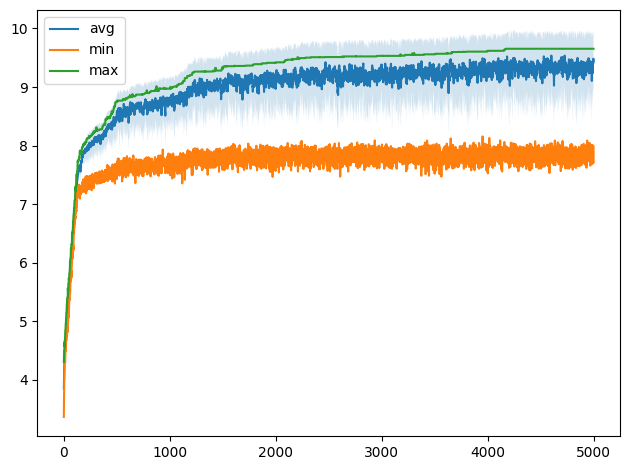

In [228]:
log = scenario.run()
draw_log(log)